# グラフの文字で英語以外を使えるようにする

In [1]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=62a06793e780b14ab876cdfd0050ff61c3f5fa4daa047f2f1585328c4b33fa76
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# 関数 save_fig：図の保存

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import japanize_matplotlib

def save_fig(plt, file_prefix, bbox_inches='tight'):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches=bbox_inches, pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches=bbox_inches, pad_inches = 0.2)

# 関数 plot_data2d：2次元データをプロットする

In [3]:
def plot_data2d(x_train, y_train, x_test, y_test, file_prefix=''):
    """2次元データをプロットする
    Args:
        x_train (ndarray): 訓練データの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_train (ndarray): 訓練データのクラス
        x_test (ndarray): テストデータの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_test (ndarray): テストデータのクラス
        file_prefix (str): グラフの保存先パス
    """
    colors=['coral', 'cornflowerblue']
    # 訓練データのマーカー。クラス0とクラス1
    markers=['o', 'o']

    plt.figure(figsize=(12, 6))

    def plot(x, y, title):
        # データのプロット
        for i in range(2):
            plt.scatter(x[y == i, 0], x[y == i, 1], c=colors[i],
                        marker=markers[i], edgecolor='black', s=100, label=f'クラス{i}')

        plt.title(title, fontsize=16)
        plt.xlim(35, 85)
        plt.ylim(35, 85)
        plt.xticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.yticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.xlabel('数学', fontsize=14)
        plt.ylabel('英語', fontsize=14)
        plt.grid()
        plt.legend(fontsize=14, loc='upper left')

    plt.subplot(1, 2, 1)
    plot(x_train, y_train, '訓練データ')

    plt.subplot(1, 2, 2)
    plot(x_test, y_test, 'テストデータ')

    plt.tight_layout()
    save_fig(plt, file_prefix)
    plt.show()

# 関数 plot_2class_result：2クラス分類結果をプロットする

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def plot_2class_result(x_train, y_train, x_test, y_test, model, file_prefix=''):
    """SVMによる分類結果を可視化する。
    Args:
        x (ndarray): 訓練データの点数
            x[i, 0]: 数学の点数
            x[i, 1]: 英語の点数
        y (ndarray): 訓練データのクラス
        model (SVC): サポートベクトルマシン
        names (list): テストデータ（生徒）の名前
        scores (ndarray): テストデータの点数
            scores[i, 0]: 数学の点数
            scores[i, 1]: 英語の点数
        file_prefix (str): グラフの保存先パス
    """

    # 決定境界（直線）パラメータ w[0] * x[0] + w[1] * x[1] + w[2] = 0のw[0]とw[1]
    w = model.coef_[0]

    ns = model.n_support_ # サポートベクトルの数

    # サポートベクトルのx_trainにおけるインデックス
    svi = model.support_;

    # 分離直線の法線ベクトル
    normal_vec = np.array([w[0], w[1], model.intercept_[0]])

    # class 0のサポートベクトル
    mv0 = svi[margin_sv(normal_vec, x_train[svi[0 : ns[0]]], -1)]

    # class 1のサポートベクトル
    mv1 = svi[margin_sv(normal_vec, x_train[svi[ns[0]:]], 1, offset=ns[0])]

    mv_idx = np.array([mv0, mv1])

    # 訓練データの描画色。クラス0とクラス1
    colors = ['coral', 'cornflowerblue']
    sv_colors = ['red', 'blue']

    # 訓練データのマーカー。クラス0とクラス1
    markers=['o', 'o']

    plt.figure(figsize=(12, 6))

    # 分離直線
    a = -w[0] / w[1]
    xx = np.linspace(35, 85, 100)
    yy = a * xx - model.intercept_[0] / w[1]

    def plot(x, y, title):
        # 分離直線の描画
        plt.plot(xx, yy, color='black',linewidth=4, linestyle='solid')

        # データのプロット
        for i in range(2):
            plt.scatter(x[y == i, 0], x[y == i, 1], c=colors[i],
                        marker=markers[i], edgecolor='black', s=100, label=f'クラス{i}')

        # 分離直線に平行かつサポートベクトルを通る直線の描画
        # 訓練データから取得
        if mv_idx is not None:
            # w1(x1 - mv1) + w2(x2 - mv2) = 0
            # x2 = -w1(x1 - mv1) / w2 + mv2 = -(w1 / w2) x1 + (w1 / w2) * mv1 + mv 2
            for i in range(len(mv_idx)):
                sv = x_train[mv_idx[i]]
                plt.plot(xx, a * xx - a * sv[0] + sv[1], color='black',linewidth=4, linestyle='dashed')

        # サポートベクトルのプロット
        # 訓練データから取得
        for i in svi:
            sv = x_train[i]
            cls = y_train[i]
            plt.scatter(sv[0], sv[1], edgecolor='black', marker='o', s=400, color=sv_colors[cls],
                        linewidth=3)
        plt.title(title, fontsize=16)
        plt.xlim(35, 85)
        plt.ylim(35, 85)
        plt.xticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.yticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.xlabel('数学', fontsize=14)
        plt.ylabel('英語', fontsize=14)
        plt.grid()
        plt.legend(fontsize=14, loc='upper left')

    plt.subplot(1, 2, 1)
    plot(x_train, y_train, '訓練データ')

    plt.subplot(1, 2, 2)
    plot(x_test, y_test, 'テストデータ')

    plt.tight_layout()
    save_fig(plt, file_prefix)
    plt.show()

# 関数 margin_sv：決定境界から最も離れたサポートベクトルを見つける

In [5]:
def margin_sv(w, sv, sign, offset=0):
    """決定境界から最も離れたサポートベクトルを見つける
    Args:
        w (ndarray): 決定境界のパラメータ。w[0] * x[0] + w[1] * x[1] + w[2] = 0
        sv (ndarray): あるクラスのサポートベクトル
        sign (int): クラスを識別する符号。クラス0に対しては-1、クラス1にたいしては+1

    Returns
        (int): svの中で決定境界から最も離れたサポートベクトルのインデックス
    """
    ds = np.zeros(len(sv))

    wlen = np.sqrt(w.dot(w))

    # サポートベクトルと決定境界との距離を計算
    for i, v in enumerate(sv):
        a = w[0] * v[0] + w[1] * v[1] + w[2]

        # 決定境界と他方のクラス側のマージンに含まれる点は符号がマイナスになる
        ds[i] = sign * a / wlen

    return np.argmax(ds) + offset

# 実習7.1：ファンシーインデックスの使い方・その2

In [6]:
import numpy as np

a = np.array([1, 1, 0, 1, 0, 0])
b = np.array([6, 5, 4, 3, 2, 1])
k=(a==1) # aの各要素について値1に等しいか判定

print('kの要素数:', len(k))
print('k:', k)

# kの要素の値がTrueとなるインデックスを使い、配列bから要素を取り出す
c = b[k]
print('cの要素数:', len(c))
print('c:', c)

kの要素数: 6
k: [ True  True False  True False False]
cの要素数: 3
c: [6 5 3]


# 実習7.2：1次元データに対するハードマージンSVMを用いる分類

In [7]:
import numpy as np
from sklearn.svm import SVC # 注意 SVMではない。SVC = Support Vector Classification

# 訓練データにおける3個の入力値
# scikit-learnでは、それぞれの入力値を配列としてとる。
# 1次元であっても、(データ数, 成分数)の2次元配列を使う必要がある
x_train=np.array([[0],  # 1個目の入力データ
                  [1],  # 2個目の入力データ
                  [2]]) # 3個目の入力データ

# 訓練データにおけるラベル
y_train=np.array([0,  # 1個目のラベル
                  0,  # 2個目のラベル
                  1]) # 3個目のラベル

# 分類器うを生成
model=SVC(kernel='linear', # 線形SVMを指定
          C=100000)        # 正則化項。次回解説

# 訓練データで学習し、決定境界を求める
model.fit(x_train, y_train)
# 決定境界 wx + b = 0
w=model.coef_[0, 0]
print('w =', w)
b=model.intercept_[0]
print('b =', b)

print('\nサポートベクトル')
# model.support_: 訓練データにおけるサポートベクトルのインデックス
for i in model.support_:
    sv=x_train[i]  # サポートベクトル
    cls=y_train[i] # クラスラベル
    print(f'クラス{cls}: {sv}')

print('\n各入力データについて、決定境界の値を調べる')
for i in range(len(x_train)):
    x=x_train[i]
    cls=y_train[i]
    d=w*x+b
    print(f'x = {x}, クラス{cls}, D(x) =', d)

w = 2.0
b = -3.0

サポートベクトル
クラス0: [1]
クラス1: [2]

各入力データについて、決定境界の値を調べる
x = [0], クラス0, D(x) = [-3.]
x = [1], クラス0, D(x) = [-1.]
x = [2], クラス1, D(x) = [1.]


# 実習7.3：2次元データの読み込み

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('dm7-1.csv', encoding='utf-8')

df

,クラス,数学,英語,種類
0,0,58,43,1
1,0,52,50,1
2,0,46,51,1
3,0,47,45,1
4,0,54,46,1
...,...,...,...,...
195,1,76,73,0
196,1,78,73,0
197,1,71,71,0
198,1,76,63,0


# 実習7.4：教師データを可視化する

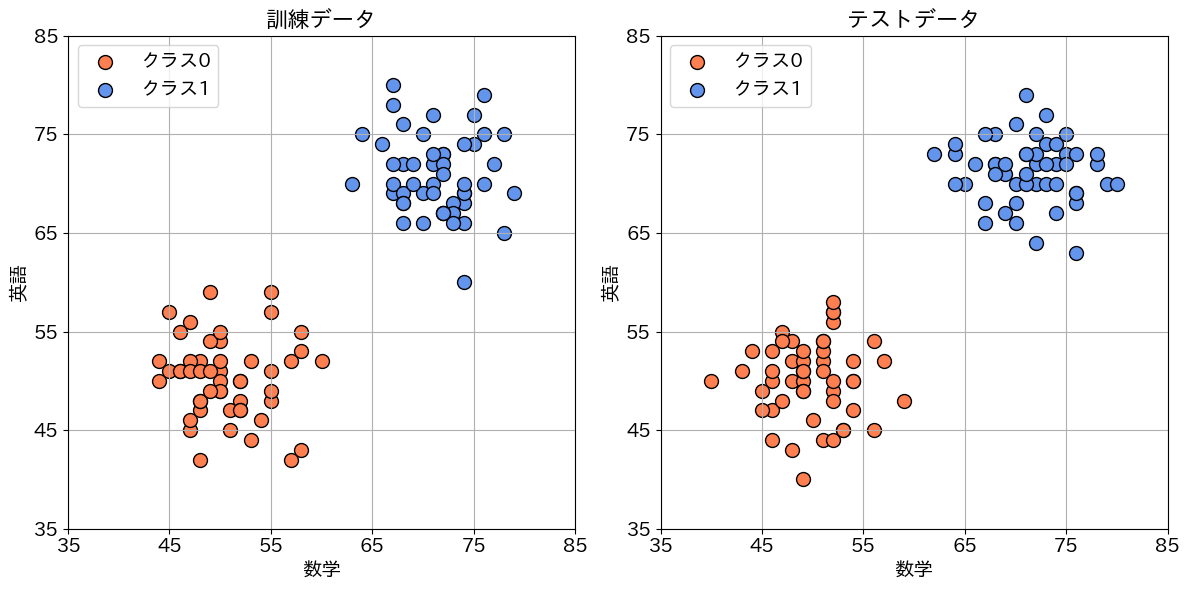

In [9]:
# 数学と英語の点をデータフレームから取り出す。Numpy配列へ変換
x=df[['数学', '英語']].to_numpy()

# クラスラベルを取り出す。Numpy配列へ変換
y=df['クラス'].to_numpy()

# データの種類を表す列をデータフレームから取り出す。Numpyへ変換
# 訓練データの場合は値1。テストデータの場合は値0
kind=df['種類'].to_numpy()

is_train=(kind==1) # 訓練データ（kindの要素値が1）かを判定
# ファンシーインデックスにより、説明変数xから訓練データ用の説明変数を取り出す。実習7.1参照
x_train=x[is_train]
# ファンシーインデックスにより、目的変数yから訓練データ用の目的変数を取り出す。実習7.1参照
y_train=y[is_train]

is_test=(kind==0) # データ（kindの要素値が0）かを判定
# ファンシーインデックスにより、説明変数xからテストデータ用の説明変数を取り出す。実習7.1参照
x_test=x[is_test]
# ファンシーインデックスにより、目的変数yからテストデータ用の目的変数を取り出す。実習7.1参照
y_test=y[is_test]

# 2次元データをプロットする
plot_data2d(x_train, y_train, x_test, y_test)

# 実習7.5：2次元データに対するハードマージンSVMを用いた分類

1.   リスト項目
2.   リスト項目



w = [[0.16669 0.49993]]
b = -38.66377333333415

サポートベクトル
クラス0: [55 57]
クラス0: [49 59]
クラス1: [55 61]


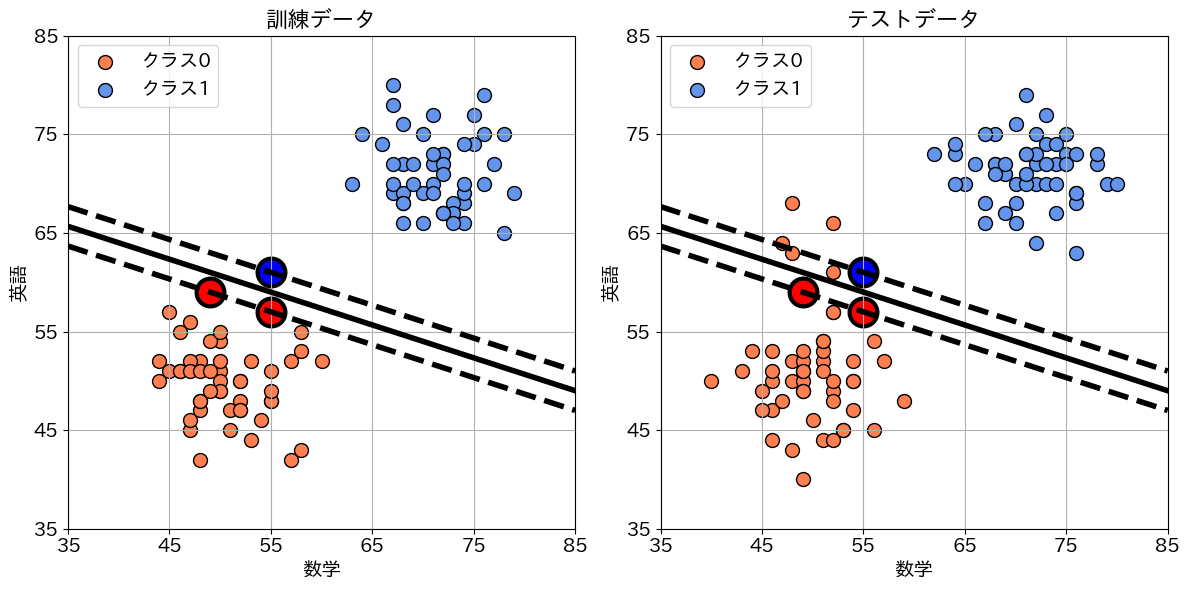

In [21]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

# 分類器を生成
model=SVC(kernel='linear', # 線形SVMを指定
          C=1000000)       # 正則化項。次回解説

# 訓練データで学習し、決定境界を求める
model.fit(x_train,y_train)

# 決定境界 w[0] * x0 + w[1] * x1 + b = 0
w=model.coef_
print('w =',w)
b=model.intercept_[0]
print('b =',b)

print('\nサポートベクトル')
for i in model.support_:
    sv=x_train[i]  # サポートベクトル
    cls=y_train[i] # クラスラベル
    print(f'クラス{cls}: {sv}')

# データと決定境界、サポートベクトルを可視化する
plot_2class_result(x_train, y_train, x_test, y_test, model)

# 実習7.6：分類性能の評価

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

print('訓練データについての分類性能')
# 訓練データに対してクラスを予測。結果をy_train_predに代入
y_train_pred=model.predict(x_train)
# 正解率。正解と予測値の順で関数に渡す
train_accuracy = accuracy_score(y_train, y_train_pred)
# 精度（average=None、各クラスについて精度を計算する）
train_precision=precision_score(y_train, y_train_pred, average=None)
# 再現率（average=None、各クラスについて再現率を計算する）
train_recall=recall_score(y_train, y_train_pred, average=None)
# F1値（average=None、各クラスについてF1値を計算する）
train_f1=f1_score(y_train, y_train_pred, average=None)
# 混同行列
train_cm=confusion_matrix(y_train, y_train_pred)

print('混同行列')
print(train_cm)
print('正解率:', train_accuracy)
print('精度:', train_precision)
print('再現率:', train_recall)
print('F1値:', train_f1)

print('テストデータについての分類性能')
# テストデータに対してクラスを予測。結果をy_test_predに代入
y_test_pred=model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision=precision_score(y_test, y_test_pred, average=None)
test_recall=recall_score(y_test, y_test_pred, average=None)
test_f1=f1_score(y_test, y_test_pred, average=None)
test_cm=confusion_matrix(y_test, y_test_pred)

print('混同行列')
print(test_cm)
print('正解率:', test_accuracy)
print('精度:', test_precision)
print('再現率:', test_recall)
print('F1値:', test_f1)

訓練データについての分類性能
混同行列
[[50  0]
 [ 0 50]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]
F1値: [1. 1.]
テストデータについての分類性能
混同行列
[[50  0]
 [ 0 50]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]
F1値: [1. 1.]


# 実習7.7：外れ値のある2次元データの読み込み

In [14]:
import pandas as pd
import numpy as np

df2 = pd.read_csv('dm7-2.csv', encoding='utf-8')

df2

,クラス,数学,英語,種類
0,0,58,43,1
1,0,52,50,1
2,0,46,51,1
3,0,47,45,1
4,0,54,46,1
...,...,...,...,...
195,1,76,73,0
196,1,78,73,0
197,1,71,71,0
198,1,76,63,0


# 実習7.8：外れ値のある教師データを可視化する

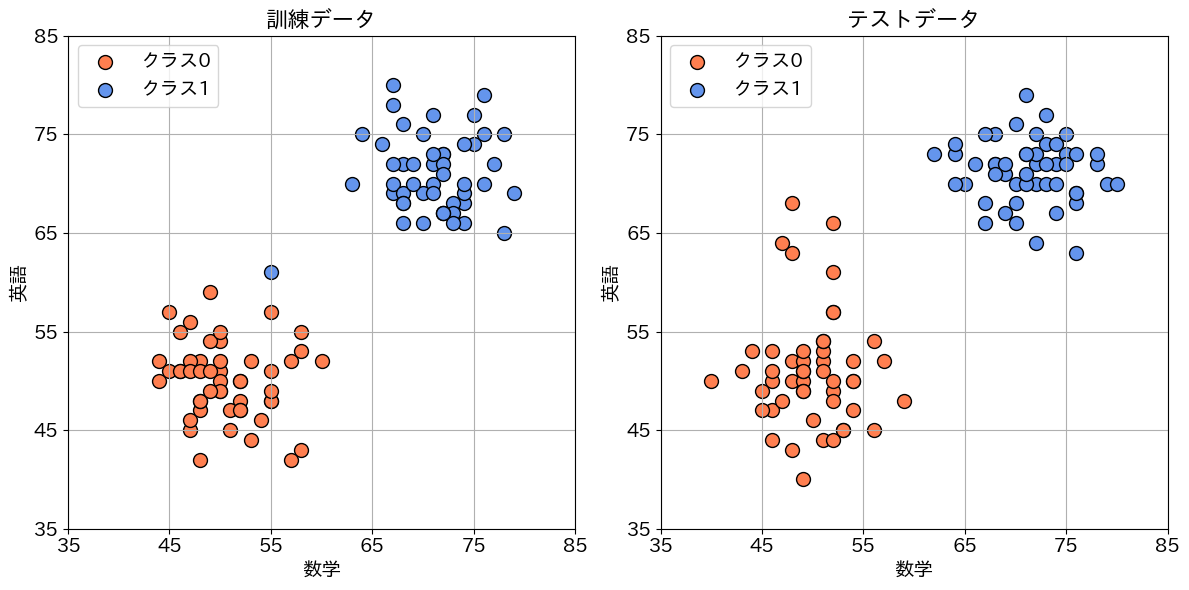

In [16]:
# 数学と英語の点をデータフレームから取り出す。Numpy配列へ変換
x=df2[['数学', '英語']].to_numpy()

# クラスラベルを取り出す。Numpy配列へ変換
y=df2['クラス'].to_numpy()

# データの種類を表す列をデータフレームから取り出す。Numpyへ変換
# 訓練データの場合は値1。テストデータの場合は値0
kind=df2['種類'].to_numpy()

is_train=(kind==1) # 訓練データ（kindの要素値が1）かを判定
# ファンシーインデックスにより、説明変数xから訓練データ用の説明変数を取り出す。実習7.1参照
x_train=x[is_train]
# ファンシーインデックスにより、目的変数yから訓練データ用の目的変数を取り出す。実習7.1参照
y_train=y[is_train]

is_test=(kind==0) # データ（kindの要素値が0）かを判定
# ファンシーインデックスにより、説明変数xからテストデータ用の説明変数を取り出す。実習7.1参照
x_test=x[is_test]
# ファンシーインデックスにより、目的変数yからテストデータ用の目的変数を取り出す。実習7.1参照
y_test=y[is_test]

# 2次元データをプロットする
plot_data2d(x_train, y_train, x_test, y_test)

# 実習7.9：外れ値のある2次元データに対するハードマージンSVMを用いた分類

w = [[0.16669 0.49993]]
b = -38.66377333333415

サポートベクトル
クラス0: [55 57]
クラス0: [49 59]
クラス1: [55 61]


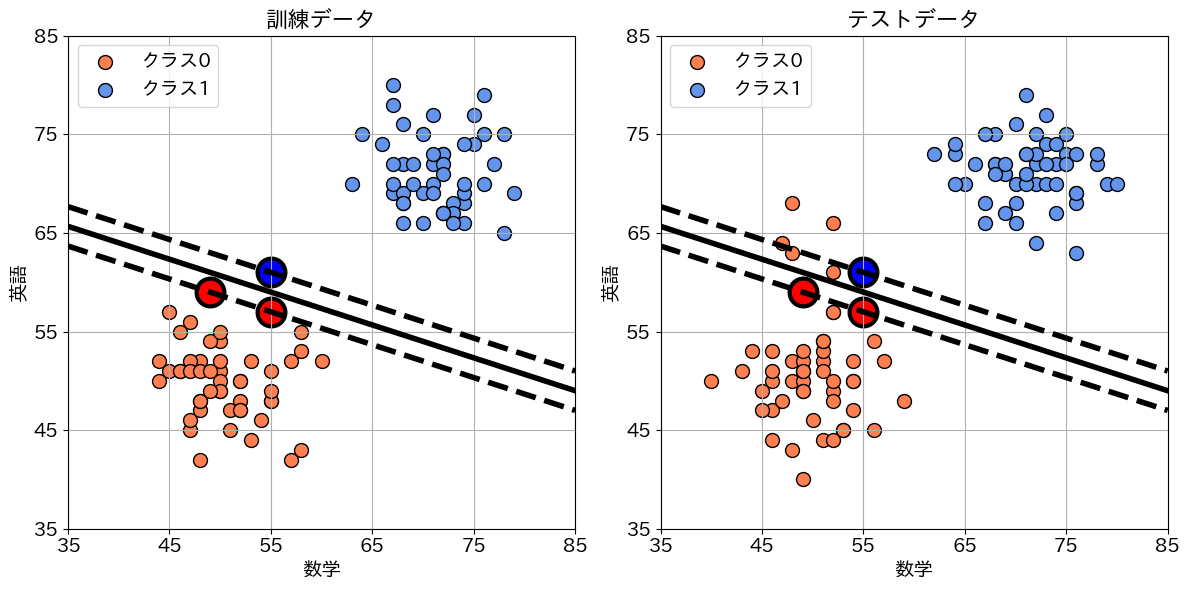

In [22]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

# 分類器を生成
model=SVC(kernel='linear', # 線形SVMを指定
          C=1000000)       # 正則化項。次回解説

# 訓練データで学習し、決定境界を求める
res=model.fit(x_train,y_train)

# 決定境界 w[0] * x0 + w[1] * x1 + b = 0
w=model.coef_
print('w =',w)
b=model.intercept_[0]
print('b =',b)

print('\nサポートベクトル')
for i in model.support_:
    sv=x_train[i]  # サポートベクトル
    cls=y_train[i] # クラスラベル
    print(f'クラス{cls}: {sv}')

# データと決定境界、サポートベクトルを可視化する
plot_2class_result(x_train, y_train, x_test, y_test, model)

# 実習7.10：外れ値のあるデータについての分類性能

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

print('訓練データについての分類性能')
# 訓練データに対してクラスを予測。結果をy_train_predに代入
y_train_pred=model.predict(x_train)
# 正解率。正解と予測値の順で関数に渡す
train_accuracy = accuracy_score(y_train, y_train_pred)
# 精度（average=None、各クラスについて精度を計算する）
train_precision=precision_score(y_train, y_train_pred, average=None)
# 再現率（average=None、各クラスについて再現率を計算する）
train_recall=recall_score(y_train, y_train_pred, average=None)
# F1値（average=None、各クラスについてF1値を計算する）
train_f1=f1_score(y_train, y_train_pred, average=None)
# 混同行列
train_cm=confusion_matrix(y_train, y_train_pred)

print('混同行列')
print(train_cm)
print('正解率:', train_accuracy)
print('精度:', train_precision)
print('再現率:', train_recall)
print('F1値:', train_f1)

print('テストデータについての分類性能')
# テストデータに対してクラスを予測。結果をy_test_predに代入
y_test_pred=model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision=precision_score(y_test, y_test_pred, average=None)
test_recall=recall_score(y_test, y_test_pred, average=None)
test_f1=f1_score(y_test, y_test_pred, average=None)
test_cm=confusion_matrix(y_test, y_test_pred)

print('混同行列')
print(test_cm)
print('正解率:', test_accuracy)
print('精度:', test_precision)
print('再現率:', test_recall)
print('F1値:', test_f1)

訓練データについての分類性能
混同行列
[[50  0]
 [ 0 50]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]
F1値: [1. 1.]
テストデータについての分類性能
混同行列
[[45  5]
 [ 0 50]]
正解率: 0.95
精度: [1.         0.90909091]
再現率: [0.9 1. ]
F1値: [0.94736842 0.95238095]
